<a href="https://colab.research.google.com/github/Arxtage/FaceRecogition-Sbertex/blob/master/u-net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Arxtage/fun

fatal: destination path 'fun' already exists and is not an empty directory.


In [0]:
import os


In [0]:
os.chdir('fun/idog')

In [3]:
!ls

AR_blocks_4_fea_8_IOU_0.1_norm_Tr  ngrok			   notebooks
idog				   ngrok-stable-linux-amd64.zip    README.md
lib				   ngrok-stable-linux-amd64.zip.1  use_cases


# New Section

In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-03-10 22:35:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.102.189, 52.202.60.111, 52.203.53.176, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.102.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14893410 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  14.20M  14.5MB/s    in 1.0s    

2019-03-10 22:35:39 (14.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [14893410/14893410]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
LOG_DIR = 'content/fun/idog/AR_blocks_4_fea_8_IOU_0.1_norm_Tr'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')


In [13]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://8dde8443.ngrok.io


In [0]:
from glob import glob

import sys
sys.path.append("/content")
import cv2
import tensorflow as tf
import numpy as np
from numpy.random import choice
import os
import random
from albumentations import ShiftScaleRotate, ChannelShuffle, RGBShift, Compose
from tqdm import tqdm_notebook 

import tensorflow as tf
import numpy as np

from tensorflow.nn import sigmoid
from idog.detection.unet import get_loss, IOU


from sklearn.utils import shuffle as sk_shuffle
from tensorflow.data import Dataset
from tensorflow.estimator import RunConfig
from glob import glob
from PIL import Image
from idog.utils.mask_generator import get_padding

from copy import copy

from idog.detection.unet import make_unet
import matplotlib.pyplot as plt

In [0]:
def augment(aug, image, mask):
    res= aug(image=image, mask = mask)
    image= res['image']
    mask= res['mask']
    return(image,mask)
  
def aug_srgb(p=0.5):
  return Compose([
      ShiftScaleRotate(p=1),
      ChannelShuffle(p=1),
      RGBShift(r_shift_limit=150, g_shift_limit=150, b_shift_limit=150)
  ],p=p)

In [0]:
def generator(image_paths, mask_paths, image_shape=(2048, 1536), shuffle=True):
    """
    Generator for Estimtor, create binary mask for it
    :param image_paths: list: list of full path of the binary masks
    :param watermark_paths: list: list of full path to pickle file with boxes
    :param threshold: int: treshhold for binary masks
    :param image_shape: (int, int): the size of image we want
    :param shuffle: bool: shuffle or not data
    :return: tuple(image,mask)
    """
    if shuffle is True:
        image_paths, mask_paths = sk_shuffle(image_paths, mask_paths)

    for image_path, mask_path in zip(image_paths, mask_paths):

        if type(image_path) == bytes:
            image_path = image_path.decode()

        if type(mask_path) == bytes:
            mask_path = mask_path.decode()
        
        image = np.array(Image.open(image_path))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        #image = get_padding(image, image_shape, 255)
        #mask = get_padding(mask, image_shape, 0)
        image = cv2.resize(image, (image_shape[1], image_shape[0]))
        mask = cv2.resize(mask, (image_shape[1], image_shape[0]))
        
        i=0
        for i in range(10):
          aug = aug_srgb(p=1)
          img,msk = augment(aug, image, mask)
          img = np.array(img)/255
          msk = msk[:,:,np.newaxis]
          msk = np.array(msk)/255
          yield img, msk
            
        image = np.array(image)/255
        mask = mask[:,:,np.newaxis]
        mask = np.array(mask)/255
        
        yield image, mask

In [0]:
def input_fn(image_paths, mask_paths, num_epochs=20, batch_size=2):
    """
    input function for Estimator, uses the generator for this
    :param binary_mask_paths: list: list of full paths of the images
    :param boxes_paths: list: list of full path to pickle file with boxes
    :param threshold: int: treshhold for binary masks
    :param num_epochs: int: the number of epoch
    :param batch_size: int: batch size
    :return: tensorflow dataset for Estimator
    """
    dataset = Dataset.from_generator(generator=generator, output_types=(tf.float32, tf.float32),
                                     output_shapes=(tf.TensorShape([2048, 1536, 3]), tf.TensorShape([2048, 1536, 1])),
                                     args=(image_paths, mask_paths))
    dataset = dataset.repeat(num_epochs).batch(batch_size)

    return dataset

def create_summary(data):
    """
    Create summary for the model
    :param data: dict: two required keys - scalar and image, values -
            lists of tuple with display name and elements of tf.graph
    :return:
    """
    for i in data["scalar"]:
        tf.summary.scalar(i[0], i[1])
    for i in data["image"]:
        tf.summary.image(i[0], i[1])

In [0]:
def make_unet_estimator(features, labels, mode, params):
    """
    Creation of tf.estimator.Estimator for U-net
    :param features: tf.Tensor: images
    :param labels: tf.Tensor: masks
    :param mode: tf.estimator.ModeKeys
    :param params: dict: params of the model
    :return: tf.estimator.EstimatorSpec
    """
    orig_images = features
    true_masks = labels
    model = params["model"]
    net = model(orig_images, **params["model_params"])
    predictions = {
        "predicted_soft_masks": sigmoid(net),
        "predicted_masks": tf.round(sigmoid(net))
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions)

    loss = get_loss(net, true_masks, lam=params["IOU_weight"])

    if params["create_summary"]:
        data = {
            "scalar": [("Loss", loss), ("IOU", IOU(net, true_masks))],
            "image": [('Original image', orig_images),
                      ("Original_masks", true_masks), ("Predicted_masks", sigmoid(net))]
        }
        create_summary(data)

    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(params["learning_rate"], global_step,
                                                   params["lr_decay_steps"], params["lr_decay_rate"], staircase=True)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        optim = tf.train.AdamOptimizer(learning_rate=learning_rate)
        with tf.control_dependencies(update_ops):
            train_op = optim.minimize(loss, global_step=global_step)
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

    eval_metric_ops = {"IOU": tf.metrics.mean(IOU(net, labels))}

    return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [0]:
image_paths = sorted(glob('/content/fun/DATA_segmentation_v2/images/*'), key=lambda x: int(x.split('/')[-1].split('.')[0]))
mask_paths = sorted(glob('/content/fun/DATA_segmentation_v2/masks/*'), key=lambda x: int(x.split('/')[-1].split('.')[0]))


number_for_train = -5
train_paths_images = image_paths[:number_for_train]
test_paths_images = image_paths[number_for_train:]

train_paths_mask = mask_paths[:number_for_train]
test_paths_mask = mask_paths[number_for_train:]

model_params = {"num_blocks": 4,
                "num_filters": 8,
                "batch_normalization": True,
                "training": True}
params = {"model": make_unet,
          "model_params": model_params,
          "IOU_weight": 0.1,
          "learning_rate": 0.001,
          "lr_decay_steps": 1000,
          "lr_decay_rate": 0.96,
          "create_summary": True}


strategy = tf.contrib.distribute.OneDeviceStrategy(device='/gpu:1')
config = RunConfig(save_summary_steps=40,
                   train_distribute=strategy,
                   save_checkpoints_steps = 200,
                   keep_checkpoint_max = 60,
                   eval_distribute=strategy,
                   )
tf.logging.set_verbosity(tf.logging.INFO)

segmentation_model = tf.estimator.Estimator(
    model_fn=make_unet_estimator,
    model_dir="./AR_blocks_4_fea_8_IOU_0.1_norm_Tr/",
    params=params,
    config=config
)

train_params = {'image_paths': train_paths_images,
          'mask_paths': train_paths_mask,
          'batch_size': 2,
          'num_epochs': 100
          }
val_params = {'image_paths': test_paths_images,
                'mask_paths': test_paths_mask,
                'batch_size': 2,
                'num_epochs': 1
                }

train_spec = tf.estimator.TrainSpec(input_fn=lambda: input_fn(**train_params), max_steps = 75000)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: input_fn(**val_params), throttle_secs=100, steps=200)
tf.estimator.train_and_evaluate(segmentation_model, train_spec, eval_spec)

segmentation_model.train(input_fn=lambda: input_fn(**params))

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': './AR_blocks_4_fea_8_IOU_0.1_norm_Tr/', '_tf_random_seed': None, '_save_summary_steps': 40, '_save_checkpoints_steps': 200, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 60, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x7fb5e865f9e8>, '_device_fn': None, '_protocol': None, '_eval_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x7fb5e865f9e8>, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb5e865fb00>, '_task_type': 'worker',

In [0]:
def image_generator(image_paths, image_shape=(1920, 1280)):
    """
    Generator for Estimtor, create binary mask for it

    :param image_paths: list: list of full path of the binary masks
    :param watermark_paths: list: list of full path to pickle file with boxes
    :param threshold: int: treshhold for binary masks
    :param image_shape: (int, int): the size of image we want
    :param shuffle: bool: shuffle or not data
    :return: tuple(image,mask)
    """

    for image_path in image_paths:

        if type(image_path) == bytes:
            image_path = image_path.decode()

        image = np.array(Image.open(image_path))
        
        #image = get_padding(image, image_shape, 255)
        #mask = get_padding(mask, image_shape, 0)
        image = cv2.resize(image, (image_shape[1], image_shape[0]))
        
        image = np.array(image)/255
        #mask = np.array(mask>0)
        yield image

In [0]:
def image_input_fn(image_paths, num_epochs=1, batch_size=5):
    """
    input function for Estimator, uses the generator for this

    :param binary_mask_paths: list: list of full paths of the images
    :param boxes_paths: list: list of full path to pickle file with boxes
    :param threshold: int: treshhold for binary masks
    :param num_epochs: int: the number of epoch
    :param batch_size: int: batch size
    :return: tensorflow dataset for Estimator
    """
    dataset = Dataset.from_generator(generator=image_generator, output_types=tf.float32,
                                     output_shapes=(tf.TensorShape([1920, 1280, 3])),
                                     args=(image_paths,))
    dataset = dataset.repeat(num_epochs).batch(batch_size)

    return dataset

In [0]:
winil = sorted(glob('/content/fun/DATA_segmentation_v2/images/*'), key=lambda x: int(x.split('/')[-1].split('.')[0]))


In [0]:
params = {'image_paths': test_paths_images}
pred = segmentation_model.predict(
    input_fn=lambda: image_input_fn(**params),
    predict_keys='predicted_masks',
    checkpoint_path=None
)

In [0]:
pred_sample = next(pred)

In [0]:
pred_sample = pred_sample['predicted_masks'][:,:,0]
pred_sample = np.array(pred_sample, dtype='uint8')

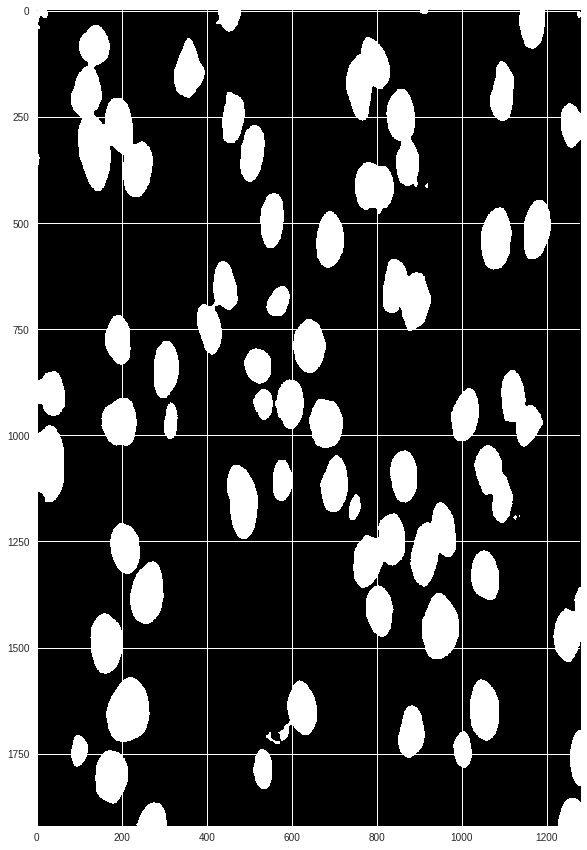

In [244]:
plt.figure(figsize=(10, 15))
plt.imshow(pred_sample, 'Greys_r')